<a href="https://colab.research.google.com/github/osterhult/SomeMLCode/blob/main/TomCruise.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# How popular will a new Tom Crusie movie be?

## Importing liberies

In [154]:
import pandas as pd
import numpy as np
import tensorflow as tf

from ast import literal_eval

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import RocCurveDisplay, roc_curve, auc
from sklearn.metrics import classification_report, log_loss 

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.compose import make_column_selector
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate

from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
import xgboost as xgb

### Handle imbalanced datasets
import imblearn

In [155]:
tf.__version__

'2.8.2'

## Getting data and inspecting it

In [379]:
#credits_data = pd.read_csv('./credits.csv')
df_movies = pd.read_csv('./movies_metadata.csv')
df_ratings = pd.read_csv('./ratings_small.csv')
df_credits = pd.read_csv('./credits.csv')


/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:3326: DtypeWarning: Columns (10) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


## Movie data

### Check out the data set

In [308]:
data_type_python = pd.DataFrame(df_movies.dtypes).T.rename({0:'python data types'})
data_type_python

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
python data types,object,object,object,object,object,object,object,object,object,object,...,object,float64,float64,object,object,object,object,object,float64,float64


In [274]:
df_movies.head()

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0
1,False,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,...,1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,...,1995-12-22,0.0,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0
3,False,NaN,16000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",...,1995-12-22,81452156.0,127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Friends are the people who let you be yourself...,Waiting to Exhale,False,6.1,34.0
4,False,"{'id': 96871, 'name': 'Father of the Bride Col...",0,"[{'id': 35, 'name': 'Comedy'}]",NaN,11862,tt0113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,...,1995-02-10,76578911.0,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,False,5.7,173.0


### Drop columns of no interest (as far as we know)

In [381]:
df_movies = df_movies.drop(columns=['adult', 'belongs_to_collection', 'homepage', 'imdb_id', 'overview', 'spoken_languages', 'tagline', 'video', 'poster_path', 'production_countries', 'original_title'])
df_movies = df_movies.drop(columns=['release_date'])


KeyError: ignored

In [382]:
df_movies.head()

,budget,genres,id,original_language,popularity,production_companies,revenue,runtime,status,title,vote_average,vote_count
0,30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",862,en,21.946943,"[{'name': 'Pixar Animation Studios', 'id': 3}]",373554033.0,81.0,Released,Toy Story,7.7,5415.0
1,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",8844,en,17.015539,"[{'name': 'TriStar Pictures', 'id': 559}, {'na...",262797249.0,104.0,Released,Jumanji,6.9,2413.0
2,0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",15602,en,11.7129,"[{'name': 'Warner Bros.', 'id': 6194}, {'name'...",0.0,101.0,Released,Grumpier Old Men,6.5,92.0
3,16000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",31357,en,3.859495,[{'name': 'Twentieth Century Fox Film Corporat...,81452156.0,127.0,Released,Waiting to Exhale,6.1,34.0
4,0,"[{'id': 35, 'name': 'Comedy'}]",11862,en,8.387519,"[{'name': 'Sandollar Productions', 'id': 5842}...",76578911.0,106.0,Released,Father of the Bride Part II,5.7,173.0


In [331]:
data_type_python = pd.DataFrame(df_movies.dtypes).T.rename({0:'python data types'})
data_type_python

,budget,genres,id,original_language,popularity,production_companies,revenue,runtime,status,title,vote_average,vote_count
python data types,object,object,object,object,object,object,float64,float64,object,object,float64,float64


### Check of there is any other status than "Released"

In [311]:
print(df_movies.status.unique())

['Released' nan 'Rumored' 'Post Production' 'In Production' 'Planned'
 'Canceled']


#### Remove all other rows than 'Released'

In [383]:
df_movies = df_movies[df_movies.status == 'Released']

In [313]:
print(df_movies.status.unique())

['Released']


### Which are the top five movies based on - 'Vote average'

In [315]:
df_movies.sort_values('vote_average', ascending=False).head()

,budget,genres,id,original_language,popularity,production_companies,revenue,runtime,status,title,vote_average,vote_count
28152,0,"[{'id': 53, 'name': 'Thriller'}]",150658,it,0.596517,"[{'name': 'Cineriz', 'id': 9387}, {'name': 'Ca...",0.0,103.0,Released,Goodbye & Amen,10.0,1.0
43473,0,"[{'id': 35, 'name': 'Comedy'}]",296901,en,0.957019,"[{'name': 'Akün Film', 'id': 34966}]",0.0,84.0,Released,Firefly,10.0,1.0
39760,0,"[{'id': 35, 'name': 'Comedy'}, {'id': 10402, '...",86360,en,0.401213,"[{'name': 'Fox Film Corporation', 'id': 5488}]",0.0,121.0,Released,Sunnyside Up,10.0,1.0
15249,0,[],37255,en,0.043068,[],0.0,120.0,Released,Ween: Live in Chicago,10.0,1.0
39845,0,"[{'id': 10749, 'name': 'Romance'}, {'id': 18, ...",403593,en,0.379968,"[{'name': 'Create Entertainment', 'id': 50089}...",0.0,101.0,Released,Bazodee,10.0,1.0


#### Any difference if a movie at least needs to have 500 votes

In [316]:
df_movies[df_movies['vote_count'] > 500].sort_values('vote_average', ascending=False).head(10)

,budget,genres,id,original_language,popularity,production_companies,revenue,runtime,status,title,vote_average,vote_count
10309,13200000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",19404,hi,34.457024,"[{'name': 'Yash Raj Films', 'id': 1569}]",1.000000e+08,190.0,Released,Dilwale Dulhania Le Jayenge,9.1,661.0
40251,0,"[{'id': 10749, 'name': 'Romance'}, {'id': 16, ...",372058,ja,34.461252,"[{'name': 'CoMix Wave Films', 'id': 10198}]",3.552983e+08,106.0,Released,Your Name.,8.5,1030.0
314,25000000,"[{'id': 18, 'name': 'Drama'}, {'id': 80, 'name...",278,en,51.645403,"[{'name': 'Castle Rock Entertainment', 'id': 9...",2.834147e+07,142.0,Released,The Shawshank Redemption,8.5,8358.0
834,6000000,"[{'id': 18, 'name': 'Drama'}, {'id': 80, 'name...",238,en,41.109264,"[{'name': 'Paramount Pictures', 'id': 4}, {'na...",2.450664e+08,175.0,Released,The Godfather,8.5,6024.0
23673,3300000,"[{'id': 18, 'name': 'Drama'}]",244786,en,64.29999,"[{'name': 'Bold Films', 'id': 2266}, {'name': ...",1.309200e+07,105.0,Released,Whiplash,8.3,4376.0
2211,20000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",637,it,39.39497,"[{'name': 'Miramax Films', 'id': 14}, {'name':...",2.294000e+08,116.0,Released,Life Is Beautiful,8.3,3643.0
2843,63000000,"[{'id': 18, 'name': 'Drama'}]",550,en,63.869599,[{'name': 'Twentieth Century Fox Film Corporat...,1.008538e+08,139.0,Released,Fight Club,8.3,9678.0
5481,15000000,"[{'id': 14, 'name': 'Fantasy'}, {'id': 12, 'na...",129,ja,41.048867,"[{'name': 'Studio Ghibli', 'id': 10342}]",2.749251e+08,125.0,Released,Spirited Away,8.3,3968.0
1152,3000000,"[{'id': 18, 'name': 'Drama'}]",510,en,35.529554,"[{'name': 'United Artists', 'id': 60}, {'name'...",1.089813e+08,133.0,Released,One Flew Over the Cuckoo's Nest,8.3,3001.0
12481,185000000,"[{'id': 18, 'name': 'Drama'}, {'id': 28, 'name...",155,en,123.167259,"[{'name': 'DC Comics', 'id': 429}, {'name': 'L...",1.004558e+09,152.0,Released,The Dark Knight,8.3,12269.0


#### Remove all movies with less than 500 votes and not english as original language (Tom Crusie only speaks english as far as I know)

In [368]:
df_movies.shape

(45014, 12)

In [384]:
df_movies['original_language'] = df_movies['original_language'].astype('str') 
df_movies = df_movies[df_movies['original_language'].str.contains('en')]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [319]:
df_movies.shape

(31952, 12)

In [385]:
df_movies = df_movies[df_movies.vote_count > 500]

In [336]:
df_movies.shape

(1958, 12)

In [386]:
df_movies[df_movies['vote_count'] > 500].sort_values('vote_average', ascending=False).head(10)


,budget,genres,id,original_language,popularity,production_companies,revenue,runtime,status,title,vote_average,vote_count
834,6000000,"[{'id': 18, 'name': 'Drama'}, {'id': 80, 'name...",238,en,41.109264,"[{'name': 'Paramount Pictures', 'id': 4}, {'na...",2.450664e+08,175.0,Released,The Godfather,8.5,6024.0
314,25000000,"[{'id': 18, 'name': 'Drama'}, {'id': 80, 'name...",278,en,51.645403,"[{'name': 'Castle Rock Entertainment', 'id': 9...",2.834147e+07,142.0,Released,The Shawshank Redemption,8.5,8358.0
2843,63000000,"[{'id': 18, 'name': 'Drama'}]",550,en,63.869599,[{'name': 'Twentieth Century Fox Film Corporat...,1.008538e+08,139.0,Released,Fight Club,8.3,9678.0
1184,30000000,"[{'id': 18, 'name': 'Drama'}, {'id': 80, 'name...",311,en,32.182851,"[{'name': 'Warner Bros.', 'id': 6194}, {'name'...",0.000000e+00,229.0,Released,Once Upon a Time in America,8.3,1104.0
1152,3000000,"[{'id': 18, 'name': 'Drama'}]",510,en,35.529554,"[{'name': 'United Artists', 'id': 60}, {'name'...",1.089813e+08,133.0,Released,One Flew Over the Cuckoo's Nest,8.3,3001.0
522,22000000,"[{'id': 18, 'name': 'Drama'}, {'id': 36, 'name...",424,en,41.725123,"[{'name': 'Universal Pictures', 'id': 33}, {'n...",3.213656e+08,195.0,Released,Schindler's List,8.3,4436.0
12481,185000000,"[{'id': 18, 'name': 'Drama'}, {'id': 28, 'name...",155,en,123.167259,"[{'name': 'DC Comics', 'id': 429}, {'name': 'L...",1.004558e+09,152.0,Released,The Dark Knight,8.3,12269.0
1176,806948,"[{'id': 18, 'name': 'Drama'}, {'id': 27, 'name...",539,en,36.826309,"[{'name': 'Paramount Pictures', 'id': 4}, {'na...",3.200000e+07,109.0,Released,Psycho,8.3,2405.0
292,8000000,"[{'id': 53, 'name': 'Thriller'}, {'id': 80, 'n...",680,en,140.950236,"[{'name': 'Miramax Films', 'id': 14}, {'name':...",2.139288e+08,154.0,Released,Pulp Fiction,8.3,8670.0
1178,13000000,"[{'id': 18, 'name': 'Drama'}, {'id': 80, 'name...",240,en,36.629307,"[{'name': 'Paramount Pictures', 'id': 4}, {'na...",4.754284e+07,200.0,Released,The Godfather: Part II,8.3,3418.0


## Fix 'Production companies' get the first one

In [387]:
df_movies['production_companies'] = df_movies['production_companies'].apply(literal_eval)
df_movies['production_companies'] = df_movies['production_companies'].apply(lambda x: [i['name'] for i in x] if isinstance(x, list) else [])
df_movies['production_companies'] = df_movies['production_companies'].apply(lambda x: x[:1] if len(x) >=1 else x)
df_movies = df_movies.explode('production_companies')

In [388]:
df_movies.head()

,budget,genres,id,original_language,popularity,production_companies,revenue,runtime,status,title,vote_average,vote_count
0,30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",862,en,21.946943,Pixar Animation Studios,373554033.0,81.0,Released,Toy Story,7.7,5415.0
1,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",8844,en,17.015539,TriStar Pictures,262797249.0,104.0,Released,Jumanji,6.9,2413.0
5,60000000,"[{'id': 28, 'name': 'Action'}, {'id': 80, 'nam...",949,en,17.924927,Regency Enterprises,187436818.0,170.0,Released,Heat,7.7,1886.0
9,58000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 28, '...",710,en,14.686036,United Artists,352194034.0,130.0,Released,GoldenEye,6.6,1194.0
15,52000000,"[{'id': 18, 'name': 'Drama'}, {'id': 80, 'name...",524,en,10.137389,Universal Pictures,116112375.0,178.0,Released,Casino,7.8,1343.0


In [340]:
df_movies[df_movies['vote_count'] > 500].sort_values('vote_average', ascending=False).head(10)

,budget,genres,id,original_language,popularity,production_companies,revenue,runtime,status,title,vote_average,vote_count
834,6000000,"[{'id': 18, 'name': 'Drama'}, {'id': 80, 'name...",238,en,41.109264,Paramount Pictures,2.450664e+08,175.0,Released,The Godfather,8.5,6024.0
314,25000000,"[{'id': 18, 'name': 'Drama'}, {'id': 80, 'name...",278,en,51.645403,Castle Rock Entertainment,2.834147e+07,142.0,Released,The Shawshank Redemption,8.5,8358.0
2843,63000000,"[{'id': 18, 'name': 'Drama'}]",550,en,63.869599,Twentieth Century Fox Film Corporation,1.008538e+08,139.0,Released,Fight Club,8.3,9678.0
1184,30000000,"[{'id': 18, 'name': 'Drama'}, {'id': 80, 'name...",311,en,32.182851,Warner Bros.,0.000000e+00,229.0,Released,Once Upon a Time in America,8.3,1104.0
1152,3000000,"[{'id': 18, 'name': 'Drama'}]",510,en,35.529554,United Artists,1.089813e+08,133.0,Released,One Flew Over the Cuckoo's Nest,8.3,3001.0
522,22000000,"[{'id': 18, 'name': 'Drama'}, {'id': 36, 'name...",424,en,41.725123,Universal Pictures,3.213656e+08,195.0,Released,Schindler's List,8.3,4436.0
12481,185000000,"[{'id': 18, 'name': 'Drama'}, {'id': 28, 'name...",155,en,123.167259,DC Comics,1.004558e+09,152.0,Released,The Dark Knight,8.3,12269.0
1176,806948,"[{'id': 18, 'name': 'Drama'}, {'id': 27, 'name...",539,en,36.826309,Paramount Pictures,3.200000e+07,109.0,Released,Psycho,8.3,2405.0
292,8000000,"[{'id': 53, 'name': 'Thriller'}, {'id': 80, 'n...",680,en,140.950236,Miramax Films,2.139288e+08,154.0,Released,Pulp Fiction,8.3,8670.0
1178,13000000,"[{'id': 18, 'name': 'Drama'}, {'id': 80, 'name...",240,en,36.629307,Paramount Pictures,4.754284e+07,200.0,Released,The Godfather: Part II,8.3,3418.0


In [389]:
df_movies['popularity'] = df_movies['popularity'].astype('float') 

In [373]:
data_type_python = pd.DataFrame(df_movies.dtypes).T.rename({0:'python data types'})
data_type_python

,budget,genres,id,original_language,popularity,production_companies,revenue,runtime,status,title,vote_average,vote_count
python data types,object,object,object,object,float64,object,float64,float64,object,object,float64,float64


In [343]:
df_movies[df_movies['vote_count'] > 500].sort_values('popularity', ascending=False).head(10)

,budget,genres,id,original_language,popularity,production_companies,revenue,runtime,status,title,vote_average,vote_count
30700,74000000,"[{'id': 10751, 'name': 'Family'}, {'id': 16, '...",211672,en,547.488298,Universal Pictures,1.156731e+09,91.0,Released,Minions,6.4,4729.0
33356,149000000,"[{'id': 28, 'name': 'Action'}, {'id': 12, 'nam...",297762,en,294.337037,Dune Entertainment,8.205804e+08,141.0,Released,Wonder Woman,7.2,5025.0
42222,160000000,"[{'id': 10751, 'name': 'Family'}, {'id': 14, '...",321612,en,287.253654,Walt Disney Pictures,1.262886e+09,129.0,Released,Beauty and the Beast,6.8,5530.0
43644,34000000,"[{'id': 28, 'name': 'Action'}, {'id': 80, 'nam...",339403,en,228.032744,Big Talk Productions,2.245113e+08,113.0,Released,Baby Driver,7.2,2083.0
24455,165000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 10751...",177572,en,213.849907,Walt Disney Pictures,6.521054e+08,102.0,Released,Big Hero 6,7.8,6289.0
26564,58000000,"[{'id': 28, 'name': 'Action'}, {'id': 12, 'nam...",293660,en,187.860492,Twentieth Century Fox Film Corporation,7.831130e+08,108.0,Released,Deadpool,7.4,11444.0
26566,200000000,"[{'id': 28, 'name': 'Action'}, {'id': 12, 'nam...",283995,en,185.330992,Walt Disney Pictures,8.634161e+08,137.0,Released,Guardians of the Galaxy Vol. 2,7.6,4858.0
14551,237000000,"[{'id': 28, 'name': 'Action'}, {'id': 12, 'nam...",19995,en,185.070892,Ingenious Film Partners,2.787965e+09,162.0,Released,Avatar,7.2,12114.0
24351,20000000,"[{'id': 28, 'name': 'Action'}, {'id': 53, 'nam...",245891,en,183.870374,Summit Entertainment,8.876166e+07,101.0,Released,John Wick,7.0,5499.0
23675,61000000,"[{'id': 9648, 'name': 'Mystery'}, {'id': 53, '...",210577,en,154.801009,Twentieth Century Fox Film Corporation,3.693304e+08,145.0,Released,Gone Girl,7.9,6023.0


## Get genres

In [390]:
df_movies['genres'] = df_movies['genres'].apply(literal_eval)
df_movies['genres'] = df_movies['genres'].apply(lambda x: [i['name'] for i in x] if isinstance(x, list) else [])
df_movies['genre'] = df_movies['genres'].apply(lambda x: x[:4] if len(x) >=4 else x)
df_movies = df_movies.explode('genre')
df_movies = df_movies.drop(columns=['genres'])

In [345]:
df_movies.head()

,budget,id,original_language,popularity,production_companies,revenue,runtime,status,title,vote_average,vote_count,genre
0,30000000,862,en,21.946943,Pixar Animation Studios,373554033.0,81.0,Released,Toy Story,7.7,5415.0,Animation
0,30000000,862,en,21.946943,Pixar Animation Studios,373554033.0,81.0,Released,Toy Story,7.7,5415.0,Comedy
0,30000000,862,en,21.946943,Pixar Animation Studios,373554033.0,81.0,Released,Toy Story,7.7,5415.0,Family
1,65000000,8844,en,17.015539,TriStar Pictures,262797249.0,104.0,Released,Jumanji,6.9,2413.0,Adventure
1,65000000,8844,en,17.015539,TriStar Pictures,262797249.0,104.0,Released,Jumanji,6.9,2413.0,Fantasy


### Convert 'id' to int

In [391]:
df_movies['id'] = df_movies['id'].astype('str').astype('int') 

### Delete rows with wrongly formated "id" (three of them) to be able to convert from object to int

In [346]:
print(df_movies[df_movies['id'].str.contains('-')])

Empty DataFrame
Columns: [budget, id, original_language, popularity, production_companies, revenue, runtime, status, title, vote_average, vote_count, genre]
Index: []


In [188]:
df_movies = df_movies.drop(df_movies.index[[19730, 29503, 35587]])

###Convert "id" from object to int

In [189]:
df_movies['id'] = df_movies['id'].astype(str).astype(int)

In [190]:
df_movies.head()

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0
1,False,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,...,1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,...,1995-12-22,0.0,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0
3,False,NaN,16000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",...,1995-12-22,81452156.0,127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Friends are the people who let you be yourself...,Waiting to Exhale,False,6.1,34.0
4,False,"{'id': 96871, 'name': 'Father of the Bride Col...",0,"[{'id': 35, 'name': 'Comedy'}]",NaN,11862,tt0113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,...,1995-02-10,76578911.0,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,False,5.7,173.0


## Credits data

### General info about dataset

In [392]:
data_type_python = pd.DataFrame(df_credits.dtypes).T.rename({0:'python data types'})
data_type_python

,cast,crew,id
python data types,object,object,int64


In [348]:
df_credits.head()

,cast,crew,id
0,"[{'cast_id': 14, 'character': 'Woody (voice)',...","[{'credit_id': '52fe4284c3a36847f8024f49', 'de...",862
1,"[{'cast_id': 1, 'character': 'Alan Parrish', '...","[{'credit_id': '52fe44bfc3a36847f80a7cd1', 'de...",8844
2,"[{'cast_id': 2, 'character': 'Max Goldman', 'c...","[{'credit_id': '52fe466a9251416c75077a89', 'de...",15602
3,"[{'cast_id': 1, 'character': ""Savannah 'Vannah...","[{'credit_id': '52fe44779251416c91011acb', 'de...",31357
4,"[{'cast_id': 1, 'character': 'George Banks', '...","[{'credit_id': '52fe44959251416c75039ed7', 'de...",11862


### Get actors name

In [393]:
df_credits['cast'] = df_credits['cast'].apply(literal_eval)

In [394]:
df_credits['cast'] = df_credits['cast'].apply(lambda x: [i['name'] for i in x] if isinstance(x, list) else [])
df_credits['cast'] = df_credits['cast'].apply(lambda x: x[:4] if len(x) >=4 else x)

In [395]:
df_credits.head()

,cast,crew,id
0,"[Tom Hanks, Tim Allen, Don Rickles, Jim Varney]","[{'credit_id': '52fe4284c3a36847f8024f49', 'de...",862
1,"[Robin Williams, Jonathan Hyde, Kirsten Dunst,...","[{'credit_id': '52fe44bfc3a36847f80a7cd1', 'de...",8844
2,"[Walter Matthau, Jack Lemmon, Ann-Margret, Sop...","[{'credit_id': '52fe466a9251416c75077a89', 'de...",15602
3,"[Whitney Houston, Angela Bassett, Loretta Devi...","[{'credit_id': '52fe44779251416c91011acb', 'de...",31357
4,"[Steve Martin, Diane Keaton, Martin Short, Kim...","[{'credit_id': '52fe44959251416c75039ed7', 'de...",11862


### Explode the list so one actor per row

In [396]:
df_credits = df_credits.explode('cast')

In [397]:
df_credits.head()

,cast,crew,id
0,Tom Hanks,"[{'credit_id': '52fe4284c3a36847f8024f49', 'de...",862
0,Tim Allen,"[{'credit_id': '52fe4284c3a36847f8024f49', 'de...",862
0,Don Rickles,"[{'credit_id': '52fe4284c3a36847f8024f49', 'de...",862
0,Jim Varney,"[{'credit_id': '52fe4284c3a36847f8024f49', 'de...",862
1,Robin Williams,"[{'credit_id': '52fe44bfc3a36847f80a7cd1', 'de...",8844


### Get director (same process as above)

In [398]:
df_credits['crew'] = df_credits['crew'].apply(literal_eval)
df_credits['crew'] = df_credits['crew'].apply(lambda x: [i['name'] for i in x] if isinstance(x, list) else [])
df_credits['director'] = df_credits['crew'].apply(lambda x: x[:1] if len(x) >=4 else x)
df_credits = df_credits.explode('director')

#### Drop crew column

In [399]:
df_credits = df_credits.drop(columns=['crew'])

In [400]:
df_credits.head()

,cast,id,director
0,Tom Hanks,862,John Lasseter
0,Tim Allen,862,John Lasseter
0,Don Rickles,862,John Lasseter
0,Jim Varney,862,John Lasseter
1,Robin Williams,8844,Larry J. Franco


## Merge Movie data and Credits data

In [401]:
df = pd.merge(df_movies, df_credits, on="id")

In [402]:
print(df.shape)
df.head()

(21419, 14)


,budget,id,original_language,popularity,production_companies,revenue,runtime,status,title,vote_average,vote_count,genre,cast,director
0,30000000,862,en,21.946943,Pixar Animation Studios,373554033.0,81.0,Released,Toy Story,7.7,5415.0,Animation,Tom Hanks,John Lasseter
1,30000000,862,en,21.946943,Pixar Animation Studios,373554033.0,81.0,Released,Toy Story,7.7,5415.0,Animation,Tim Allen,John Lasseter
2,30000000,862,en,21.946943,Pixar Animation Studios,373554033.0,81.0,Released,Toy Story,7.7,5415.0,Animation,Don Rickles,John Lasseter
3,30000000,862,en,21.946943,Pixar Animation Studios,373554033.0,81.0,Released,Toy Story,7.7,5415.0,Animation,Jim Varney,John Lasseter
4,30000000,862,en,21.946943,Pixar Animation Studios,373554033.0,81.0,Released,Toy Story,7.7,5415.0,Comedy,Tom Hanks,John Lasseter


# Here are we so far....

In [415]:
print(df[df['cast'] == 'Tom Cruise'].title.unique().size)
print(df[df['cast'] == 'Tom Cruise'].title.unique())

25
['Interview with the Vampire' 'The Firm' 'Mission: Impossible' 'Top Gun'
 'Jerry Maguire' 'Rain Man' 'A Few Good Men' 'Eyes Wide Shut' 'Magnolia'
 'Mission: Impossible II' 'Vanilla Sky' 'Minority Report'
 'The Last Samurai' 'Collateral' 'War of the Worlds'
 'Mission: Impossible III' 'Valkyrie' 'Knight and Day'
 'Mission: Impossible - Ghost Protocol' 'Jack Reacher' 'Oblivion'
 'Edge of Tomorrow' 'Mission: Impossible - Rogue Nation'
 'Jack Reacher: Never Go Back' 'The Mummy']


In [425]:
df[df['cast'] == 'Tom Cruise'].sort_values('vote_average', ascending=False).head(10)

,budget,id,original_language,popularity,production_companies,revenue,runtime,status,title,vote_average,vote_count,genre,cast,director
2893,25000000,380,en,11.267467,United Artists,412800000.0,133.0,Released,Rain Man,7.6,1762.0,Drama,Tom Cruise,Hans Zimmer
17451,178000000,137113,en,31.982986,Village Roadshow Pictures,370541256.0,113.0,Released,Edge of Tomorrow,7.6,4979.0,Science Fiction,Tom Cruise,Doug Liman
17447,178000000,137113,en,31.982986,Village Roadshow Pictures,370541256.0,113.0,Released,Edge of Tomorrow,7.6,4979.0,Action,Tom Cruise,Doug Liman
4407,37000000,334,en,9.091636,New Line Cinema,48451803.0,188.0,Released,Magnolia,7.5,844.0,Drama,Tom Cruise,Paul Thomas Anderson
7108,140000000,616,en,19.582325,Cruise/Wagner Productions,456758981.0,154.0,Released,The Last Samurai,7.3,1946.0,War,Tom Cruise,Hans Zimmer
7100,140000000,616,en,19.582325,Cruise/Wagner Productions,456758981.0,154.0,Released,The Last Samurai,7.3,1946.0,Drama,Tom Cruise,Hans Zimmer
7104,140000000,616,en,19.582325,Cruise/Wagner Productions,456758981.0,154.0,Released,The Last Samurai,7.3,1946.0,Action,Tom Cruise,Hans Zimmer
7112,140000000,616,en,19.582325,Cruise/Wagner Productions,456758981.0,154.0,Released,The Last Samurai,7.3,1946.0,History,Tom Cruise,Hans Zimmer
329,60000000,628,en,11.970205,Geffen Pictures,223664608.0,123.0,Released,Interview with the Vampire,7.2,1558.0,Romance,Tom Cruise,Anne Rice
325,60000000,628,en,11.970205,Geffen Pictures,223664608.0,123.0,Released,Interview with the Vampire,7.2,1558.0,Horror,Tom Cruise,Anne Rice


# STOP ==========================

In [ ]:
#

## Ratings data

In [357]:
data_type_python = pd.DataFrame(df_ratings.dtypes).T.rename({0:'python data types'})
data_type_python

,userId,movieId,rating,timestamp
python data types,int64,int64,float64,int64


In [358]:
print(df_ratings.shape)
df_ratings.head()

(100004, 4)


,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205


###Get average rating based on movieId

In [359]:
df_ratings_avg = df_ratings.groupby('movieId')['rating'].mean()


In [360]:
print(df_ratings_avg.shape)
df_ratings_avg.head()

(9066,)


movieId
1    3.872470
2    3.401869
3    3.161017
4    2.384615
5    3.267857
Name: rating, dtype: float64

### Rename id column to better fit a merge

In [153]:
#df_ratings_avg.rename(columns = {'movieId':'id'}, inplace = True)

In [ ]:
df_ratings_avg.info()

In [35]:
tmp_data = pd.merge(credits_data, movies_data, on="id")

In [36]:
data_type_python = pd.DataFrame(tmp_data.dtypes).T.rename({0:'python data types'})
data_type_python

,cast,crew,id,adult,belongs_to_collection,budget,genres,homepage,imdb_id,original_language,...,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
python data types,object,object,int64,object,object,object,object,object,object,object,...,object,float64,float64,object,object,object,object,object,float64,float64


In [37]:
tmp_data.head()

,cast,crew,id,adult,belongs_to_collection,budget,genres,homepage,imdb_id,original_language,...,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
0,"[{'cast_id': 14, 'character': 'Woody (voice)',...","[{'credit_id': '52fe4284c3a36847f8024f49', 'de...",862,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,tt0114709,en,...,1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0
1,"[{'cast_id': 1, 'character': 'Alan Parrish', '...","[{'credit_id': '52fe44bfc3a36847f80a7cd1', 'de...",8844,False,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,tt0113497,en,...,1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0
2,"[{'cast_id': 2, 'character': 'Max Goldman', 'c...","[{'credit_id': '52fe466a9251416c75077a89', 'de...",15602,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",NaN,tt0113228,en,...,1995-12-22,0.0,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0
3,"[{'cast_id': 1, 'character': ""Savannah 'Vannah...","[{'credit_id': '52fe44779251416c91011acb', 'de...",31357,False,NaN,16000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,tt0114885,en,...,1995-12-22,81452156.0,127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Friends are the people who let you be yourself...,Waiting to Exhale,False,6.1,34.0
4,"[{'cast_id': 1, 'character': 'George Banks', '...","[{'credit_id': '52fe44959251416c75039ed7', 'de...",11862,False,"{'id': 96871, 'name': 'Father of the Bride Col...",0,"[{'id': 35, 'name': 'Comedy'}]",NaN,tt0113041,en,...,1995-02-10,76578911.0,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,False,5.7,173.0


In [38]:
ratings_data.rename(columns = {'movieId':'id'}, inplace = True)

In [39]:
ratings_data.head()

,userId,id,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205


In [40]:
print(ratings_data.shape)

(100004, 4)


In [41]:
avg_ratings_data = ratings_data.groupby('id')['rating'].mean()

print(avg_ratings_data.shape)
#avg_ratings_data.head()

(9066,)


In [42]:
avg_ratings_data.head()

id
1    3.872470
2    3.401869
3    3.161017
4    2.384615
5    3.267857
Name: rating, dtype: float64

In [112]:
full_movie_data = pd.merge(tmp_data, avg_ratings_data, on="id")

In [113]:
full_movie_data.head()

,cast,crew,id,adult,belongs_to_collection,budget,genres,homepage,imdb_id,original_language,...,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count,rating
0,"[{'cast_id': 25, 'character': 'Lt. Vincent Han...","[{'credit_id': '52fe4292c3a36847f802916d', 'de...",949,False,NaN,60000000,"[{'id': 28, 'name': 'Action'}, {'id': 80, 'nam...",NaN,tt0113277,en,...,187436818.0,170.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,A Los Angeles Crime Saga,Heat,False,7.7,1886.0,3.593750
1,"[{'cast_id': 1, 'character': 'James Bond', 'cr...","[{'credit_id': '52fe426ec3a36847f801e14b', 'de...",710,False,"{'id': 645, 'name': 'James Bond Collection', '...",58000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 28, '...",http://www.mgm.com/view/movie/757/Goldeneye/,tt0113189,en,...,352194034.0,130.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,No limits. No fears. No substitutes.,GoldenEye,False,6.6,1194.0,1.500000
2,"[{'cast_id': 1, 'character': 'Morgan Adams', '...","[{'credit_id': '52fe42f4c3a36847f802f69f', 'de...",1408,False,NaN,98000000,"[{'id': 28, 'name': 'Action'}, {'id': 12, 'nam...",NaN,tt0112760,en,...,10017322.0,119.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,The Course Has Been Set. There Is No Turning B...,Cutthroat Island,False,5.7,137.0,3.616279
3,"[{'cast_id': 4, 'character': ""Sam 'Ace' Rothst...","[{'credit_id': '52fe424dc3a36847f80139cd', 'de...",524,False,NaN,52000000,"[{'id': 18, 'name': 'Drama'}, {'id': 80, 'name...",NaN,tt0112641,en,...,116112375.0,178.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,No one stays at the top forever.,Casino,False,7.8,1343.0,3.555556
4,"[{'cast_id': 6, 'character': 'Marianne Dashwoo...","[{'credit_id': '52fe43cec3a36847f807101f', 'de...",4584,False,NaN,16500000,"[{'id': 18, 'name': 'Drama'}, {'id': 10749, 'n...",NaN,tt0114388,en,...,135000000.0,136.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Lose your heart and come to your senses.,Sense and Sensibility,False,7.2,364.0,5.000000


In [114]:
data_type_python = pd.DataFrame(full_movie_data.dtypes).T.rename({0:'python data types'})
data_type_python

,cast,crew,id,adult,belongs_to_collection,budget,genres,homepage,imdb_id,original_language,...,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count,rating
python data types,object,object,int64,object,object,object,object,object,object,object,...,float64,float64,object,object,object,object,object,float64,float64,float64


In [115]:
#strip = lambda x: str(x).replace(" ", "").lower()
#cast = full_movie_data['cast'].apply(lambda x: [strip(i) for i in x])

from ast import literal_eval

full_movie_data['cast'] = full_movie_data['cast'].apply(literal_eval)

In [116]:
full_movie_data['cast'] = full_movie_data['cast'].apply(lambda x: [i['name'] for i in x] if isinstance(x, list) else [])

full_movie_data['cast'] = full_movie_data['cast'].apply(lambda x: x[:4] if len(x) >=4 else x)

In [117]:
#print(full_movie_data[full_movie_data['cast'] == 'Tom Cruise'].count)

#full_movie_data.loc[full_movie_data['cast'].isin('Tom Cruise')]
#print(full_movie_data.loc[full_movie_data['cast'].isin(['Izabella'])])

full_movie_data['cast'].head()


0    [Al Pacino, Robert De Niro, Val Kilmer, Jon Vo...
1    [Pierce Brosnan, Sean Bean, Izabella Scorupco,...
2    [Geena Davis, Matthew Modine, Frank Langella, ...
3    [Robert De Niro, Sharon Stone, Joe Pesci, Jame...
4    [Kate Winslet, Emma Thompson, Hugh Grant, Tom ...
Name: cast, dtype: object

In [118]:
full_movie_data.cast[0]

['Al Pacino', 'Robert De Niro', 'Val Kilmer', 'Jon Voight']

# Removing a lot of columns that might not be needed

In [119]:
#data_type_python = pd.DataFrame(full_movie_data.dtypes).T.rename({0:'python data types'})
#data_type_python

full_movie_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2834 entries, 0 to 2833
Data columns (total 27 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   cast                   2834 non-null   object 
 1   crew                   2834 non-null   object 
 2   id                     2834 non-null   int64  
 3   adult                  2834 non-null   object 
 4   belongs_to_collection  539 non-null    object 
 5   budget                 2834 non-null   object 
 6   genres                 2834 non-null   object 
 7   homepage               579 non-null    object 
 8   imdb_id                2834 non-null   object 
 9   original_language      2834 non-null   object 
 10  original_title         2834 non-null   object 
 11  overview               2813 non-null   object 
 12  popularity             2834 non-null   object 
 13  poster_path            2830 non-null   object 
 14  production_companies   2834 non-null   object 
 15  prod

## Drop columns

In [120]:
full_movie_data = full_movie_data.drop(columns=
        ['id', 'crew', 'adult', 'belongs_to_collection', 'homepage', 'imdb_id', 'poster_path', 'tagline', 'video', 'original_title', 'overview', 'production_countries']
                                       )

full_movie_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2834 entries, 0 to 2833
Data columns (total 17 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   cast                  2834 non-null   object 
 1   budget                2834 non-null   object 
 2   genres                2834 non-null   object 
 3   original_language     2834 non-null   object 
 4   overview              2813 non-null   object 
 5   popularity            2834 non-null   object 
 6   production_companies  2834 non-null   object 
 7   production_countries  2834 non-null   object 
 8   release_date          2833 non-null   object 
 9   revenue               2834 non-null   float64
 10  runtime               2831 non-null   float64
 11  spoken_languages      2834 non-null   object 
 12  status                2833 non-null   object 
 13  title                 2834 non-null   object 
 14  vote_average          2834 non-null   float64
 15  vote_count           

(2834, 17)

# explode cast list

In [123]:
full_movie_data = full_movie_data.explode('cast')

In [124]:
full_movie_data.shape


(11101, 17)

In [125]:
full_movie_data.head()

,cast,budget,genres,original_language,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,title,vote_average,vote_count,rating
0,Al Pacino,60000000,"[{'id': 28, 'name': 'Action'}, {'id': 80, 'nam...",en,"Obsessive master thief, Neil McCauley leads a ...",17.924927,"[{'name': 'Regency Enterprises', 'id': 508}, {...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-15,187436818.0,170.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Heat,7.7,1886.0,3.59375
0,Robert De Niro,60000000,"[{'id': 28, 'name': 'Action'}, {'id': 80, 'nam...",en,"Obsessive master thief, Neil McCauley leads a ...",17.924927,"[{'name': 'Regency Enterprises', 'id': 508}, {...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-15,187436818.0,170.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Heat,7.7,1886.0,3.59375
0,Val Kilmer,60000000,"[{'id': 28, 'name': 'Action'}, {'id': 80, 'nam...",en,"Obsessive master thief, Neil McCauley leads a ...",17.924927,"[{'name': 'Regency Enterprises', 'id': 508}, {...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-15,187436818.0,170.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Heat,7.7,1886.0,3.59375
0,Jon Voight,60000000,"[{'id': 28, 'name': 'Action'}, {'id': 80, 'nam...",en,"Obsessive master thief, Neil McCauley leads a ...",17.924927,"[{'name': 'Regency Enterprises', 'id': 508}, {...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-15,187436818.0,170.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Heat,7.7,1886.0,3.59375
1,Pierce Brosnan,58000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 28, '...",en,James Bond must unmask the mysterious head of ...,14.686036,"[{'name': 'United Artists', 'id': 60}, {'name'...","[{'iso_3166_1': 'GB', 'name': 'United Kingdom'...",1995-11-16,352194034.0,130.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,GoldenEye,6.6,1194.0,1.50000


# checking if a person is in cast list

In [126]:
print(full_movie_data[full_movie_data['cast'] == 'Tom Cruise'].count)

#full_movie_data.loc[full_movie_data['cast'].isin('Tom Cruise')]
#print(full_movie_data.loc[full_movie_data['cast'].isin(['Izabella'])])

<bound method DataFrame.count of             cast     budget  \
42    Tom Cruise   60000000   
119   Tom Cruise   80000000   
192   Tom Cruise   60000000   
380   Tom Cruise   25000000   
440   Tom Cruise   40000000   
524   Tom Cruise   65000000   
596   Tom Cruise   37000000   
664   Tom Cruise  125000000   
864   Tom Cruise   68000000   
927   Tom Cruise  102000000   
1147  Tom Cruise  140000000   
1537  Tom Cruise  132000000   
1650  Tom Cruise  150000000   
1869  Tom Cruise   35000000   
1974  Tom Cruise   75000000   

                                                 genres original_language  \
42    [{'id': 27, 'name': 'Horror'}, {'id': 10749, '...                en   
119   [{'id': 12, 'name': 'Adventure'}, {'id': 28, '...                en   
192                   [{'id': 12, 'name': 'Adventure'}]                en   
380                       [{'id': 18, 'name': 'Drama'}]                en   
440                       [{'id': 18, 'name': 'Drama'}]                en   
524   [{

In [55]:
data_type_python = pd.DataFrame(movies_data.dtypes).T.rename({0:'python data types'})
data_type_python

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
python data types,object,object,object,object,object,int64,object,object,object,object,...,object,float64,float64,object,object,object,object,object,float64,float64


In [13]:
movies_data.head()

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0
1,False,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,...,1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,...,1995-12-22,0.0,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0
3,False,NaN,16000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",...,1995-12-22,81452156.0,127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Friends are the people who let you be yourself...,Waiting to Exhale,False,6.1,34.0
4,False,"{'id': 96871, 'name': 'Father of the Bride Col...",0,"[{'id': 35, 'name': 'Comedy'}]",NaN,11862,tt0113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,...,1995-02-10,76578911.0,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,False,5.7,173.0


In [5]:
avg_ratings = ratings_data.groupby('movieId')['rating'].mean()

print(avg_ratings.shape)
avg_ratings.head()

(9066,)


movieId
1    3.872470
2    3.401869
3    3.161017
4    2.384615
5    3.267857
Name: rating, dtype: float64

In [ ]:
movie_data = pd.merge(avg_ratings, movies_data, on="id")

## Drop all TV shows since Tom Cruise haven't done many shows

In [ ]:
print(data['type'].value_counts().head(10))

MOVIE    61706
SHOW      4687
Name: type, dtype: int64


In [ ]:
data = data[data['type'] != 'SHOW']

print(data['type'].value_counts().head())
print(data.shape)

MOVIE    61706
Name: type, dtype: int64
(61706, 19)


In [ ]:
print(data[data['name'] == 'Steven Spielberg'].count)
    
#    and data['role'] == 'DIRECTOR'].head(10))

#print(data[data['name'] == 'Tom Cruise' and data['role'] == 'DIRECTOR'].head(10))

<bound method DataFrame.count of        person_id        id              name  \
15068       2779  tm126527  Steven Spielberg   
15406       2779  tm173440  Steven Spielberg   
18992       2779  tm184504  Steven Spielberg   
20104       2779  tm193042  Steven Spielberg   
20105       2779  tm193042  Steven Spielberg   
30332       2779   tm34471  Steven Spielberg   
44534       2779  tm166550  Steven Spielberg   
44774       2779  tm158112  Steven Spielberg   
52796       2779  tm221873  Steven Spielberg   
53683       2779  tm236637  Steven Spielberg   
54175       2779  tm225321  Steven Spielberg   
55791       2779  tm347715  Steven Spielberg   
63154       2779  tm453779  Steven Spielberg   

                                      character      role  \
15068                                       NaN  DIRECTOR   
15406   Man in Electric Wheelchair (uncredited)     ACTOR   
18992                                       NaN  DIRECTOR   
20104           Popcorn-Eating Man (uncredited)   

In [ ]:
data_null_total = pd.DataFrame(data.isna().sum()).T.rename({0:'total null'})
data_null_total

,person_id,id,name,character,role,title,type,description,release_year,age_certification,runtime,genres,production_countries,seasons,imdb_id,imdb_score,imdb_votes,tmdb_popularity,tmdb_score
total null,0,0,0,4505,0,0,0,11,0,15693,0,0,0,61706,2940,3104,3169,0,869


In [ ]:
print(data.nunique())

person_id               44872
id                       3120
name                    44625
character               41689
role                        2
title                    3089
type                        2
description              3112
release_year              114
age_certification          11
runtime                   194
genres                   1107
production_countries      266
seasons                    23
imdb_id                  2835
imdb_score                 72
imdb_votes               2534
tmdb_popularity          2846
tmdb_score                 65
dtype: int64


In [ ]:
print(data['imdb_score'].value_counts().head(10))

7.4    2916
7.2    2824
7.5    2558
6.5    2473
7.3    2458
6.7    2386
7.1    2303
6.3    2270
7.0    2188
6.4    2172
Name: imdb_score, dtype: int64


In [ ]:
# categorical
column_categorical = list(data.columns)
column_categorical.remove('tenure')
column_categorical.remove('MonthlyCharges')
column_categorical.remove('TotalCharges')

column_categorical

variation_categorical = dict()

for col in column_categorical:
  tmp = data[col].unique().tolist()
  tmp.sort()
  variation_categorical[col] = ', '.join(str(item) for item in tmp)

tmp = pd.Series(variation_categorical)
data_variation_categorical = pd.DataFrame(tmp).T.rename({0:'data variation'})
data_variation_categorical

### Deleting the customerID column 
Since it will not bring anything to the model (only unique values)

In [ ]:
data.drop('customerID',axis=1,inplace=True)

### Checking out which type each column of the dataset has

In [ ]:
data_type_python = pd.DataFrame(data.dtypes).T.rename({0:'python data types'})
data_type_python

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
python data types,object,int64,object,object,int64,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object


### Check for missing values in columns

In [ ]:
data_count = pd.DataFrame(data.count()).T.rename({0:'total data'})
data_count

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
total data,5374,5374,5374,5374,5374,5374,5374,5374,5374,5374,5374,5374,5374,5374,5374,5374,5374,5374,5363,5374


### Check for null values in columns

In [ ]:
data_null_total = pd.DataFrame(data.isna().sum()).T.rename({0:'total null'})
data_null_total

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
total null,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,11,0


### Since all the missing values where where null values replacing null with 0

In [ ]:
data['TotalCharges'].fillna(0, inplace=True)
data['TotalCharges'].isna().sum()

KeyError: ignored

### Numerical and Categorical data

In [ ]:
# numerical
column_numerical = ['tenure', 'MonthlyCharges', 'TotalCharges']

# categorical
column_categorical = list(data.columns)
column_categorical.remove('tenure')
column_categorical.remove('MonthlyCharges')
column_categorical.remove('TotalCharges')

column_categorical

data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5374 entries, 0 to 5373
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   gender            5374 non-null   object
 1   SeniorCitizen     5374 non-null   int64 
 2   Partner           5374 non-null   object
 3   Dependents        5374 non-null   object
 4   tenure            5374 non-null   int64 
 5   PhoneService      5374 non-null   object
 6   MultipleLines     5374 non-null   object
 7   InternetService   5374 non-null   object
 8   OnlineSecurity    5374 non-null   object
 9   OnlineBackup      5374 non-null   object
 10  DeviceProtection  5374 non-null   object
 11  TechSupport       5374 non-null   object
 12  StreamingTV       5374 non-null   object
 13  StreamingMovies   5374 non-null   object
 14  Contract          5374 non-null   object
 15  PaperlessBilling  5374 non-null   object
 16  PaymentMethod     5374 non-null   object
 17  MonthlyCharges

### Variation in each data column

In [ ]:
variation_categorical = dict()

for col in column_categorical:
  tmp = data[col].unique().tolist()
  tmp.sort()
  variation_categorical[col] = ', '.join(str(item) for item in tmp)

tmp = pd.Series(variation_categorical)
data_variation_categorical = pd.DataFrame(tmp).T.rename({0:'data variation'})
data_variation_categorical


,gender,SeniorCitizen,Partner,Dependents,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,Churn
data variation,"Female, Male","0, 1","No, Yes","No, Yes","No, Yes","No, No phone service, Yes","DSL, Fiber optic, No","No, No internet service, Yes","No, No internet service, Yes","No, No internet service, Yes","No, No internet service, Yes","No, No internet service, Yes","No, No internet service, Yes","Month-to-month, One year, Two year","No, Yes","Bank transfer (automatic), Credit card (automa...","No, Yes"


## Preprocessing the data

### Replacing "No..." with a simple "No" makes a few more feature "binery"

In [ ]:
# replace redundant values
data.replace({'No phone service':'No',
            'No internet service':'No'},
            inplace=True)

### Turning "binary" columns into 0:s and 1:s

In [ ]:
from sklearn.preprocessing import LabelEncoder

binerycat = ['gender','Partner','Dependents','PhoneService', 'MultipleLines', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'PaperlessBilling','Churn']

# Encode Categorical Columns
le = LabelEncoder()
data[binerycat] = data[binerycat].apply(le.fit_transform)


In [ ]:
data.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,0,0,1,0,1,0,0,DSL,0,1,0,0,0,0,Month-to-month,1,Electronic check,"29,85","29,85",0
1,1,0,0,0,34,1,0,DSL,1,0,1,0,0,0,One year,0,Mailed check,"56,95","1889,5",0
2,1,0,0,0,45,0,0,DSL,1,0,1,1,0,0,One year,0,Bank transfer (automatic),"42,3","1840,75",0
3,1,0,0,1,22,1,1,Fiber optic,0,1,0,0,1,0,Month-to-month,1,Credit card (automatic),"89,1","1949,4",0
4,0,0,0,0,10,0,0,DSL,1,0,0,0,0,0,Month-to-month,0,Mailed check,"29,75","301,9",0


### Turning columns with numerical data into numerical (floats)

In [ ]:

data['MonthlyCharges'] = data['MonthlyCharges'].apply(lambda x: str(x).replace(',', '.'))
data['TotalCharges'] = data['TotalCharges'].apply(lambda x: str(x).replace(',', '.'))

data['MonthlyCharges'] = data['MonthlyCharges'].astype(float, errors = 'raise')
data['TotalCharges'] = data['TotalCharges'].astype(float, errors = 'raise')

### Checking the datatypes of the dataset

In [ ]:
data_type_python = pd.DataFrame(data.dtypes).T.rename({0:'python data types'})
data_type_python

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
python data types,int64,int64,int64,int64,int64,int64,int64,object,int64,int64,int64,int64,int64,int64,object,int64,object,float64,float64,int64


### Handle categorical columns

In [ ]:

 # Simple function to check if a column is categorical  
def is_categorical(array_like):
    return array_like.dtype.name == 'category'

# All categorical columns
object_cols = [col for col in data.columns if data[col].dtype == "object"
               or is_categorical(data[col])]

# Columns that will be one-hot encoded (less than 10 unique values)
categorical_cols = [col for col in object_cols if data[col].nunique() < 10]
categorical_cols


['InternetService', 'Contract', 'PaymentMethod']

## Make a ColumnTransformer to preprocess rest of the data

### Standard scale the numeric data and one hot encode the categorical data

In [ ]:
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])
    
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

### Put togheter the preprocessor

In [ ]:
numeric_features = ['tenure', 'MonthlyCharges', 'TotalCharges']
categorical_features = categorical_cols

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

### Making the features and the target

In [ ]:
X = data.drop('Churn', axis=1)
y = data['Churn']

In [ ]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5374 entries, 0 to 5373
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            5374 non-null   int64  
 1   SeniorCitizen     5374 non-null   int64  
 2   Partner           5374 non-null   int64  
 3   Dependents        5374 non-null   int64  
 4   tenure            5374 non-null   int64  
 5   PhoneService      5374 non-null   int64  
 6   MultipleLines     5374 non-null   int64  
 7   InternetService   5374 non-null   object 
 8   OnlineSecurity    5374 non-null   int64  
 9   OnlineBackup      5374 non-null   int64  
 10  DeviceProtection  5374 non-null   int64  
 11  TechSupport       5374 non-null   int64  
 12  StreamingTV       5374 non-null   int64  
 13  StreamingMovies   5374 non-null   int64  
 14  Contract          5374 non-null   object 
 15  PaperlessBilling  5374 non-null   int64  
 16  PaymentMethod     5374 non-null   object 


## Machine Learning part more or less starts here

### Preprocess the data

In [ ]:
X = preprocessor.fit_transform(X)

### Splitting up data to train and test sets

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

## Set up of different classifiers to see which one matches the problem the best

### Start with a neural network

#### Initliazing the ANN

In [ ]:
ann = tf.keras.models.Sequential()

Metal device set to: Apple M1

systemMemory: 8.00 GB
maxCacheSize: 2.67 GB



2022-06-22 16:09:24.355409: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-06-22 16:09:24.356320: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


#### Adding the input layer and the first hidden layer

In [ ]:
ann.add(tf.keras.layers.Dense(units=6, activation='relu'))

#### Adding the second hidden layer

In [ ]:
ann.add(tf.keras.layers.Dense(units=6, activation='relu'))

#### Adding the output layer

In [ ]:
ann.add(tf.keras.layers.Dense(units=1, activation='sigmoid'))

#### Compiling the ann

In [ ]:
ann.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

#### Training the ann on the training set

In [ ]:
ann.fit(X_train, y_train, batch_size=32, epochs=100)

2022-06-22 16:09:24.781817: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2022-06-22 16:09:24.785785: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-06-22 16:09:24.975199: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


Epoch 1/100
135/135 [==============================] - 1s 8ms/step - loss: 0.5965 - accuracy: 0.7846
Epoch 2/100
135/135 [==============================] - 1s 8ms/step - loss: 0.2498 - accuracy: 0.9623
Epoch 3/100
135/135 [==============================] - 1s 7ms/step - loss: 0.1484 - accuracy: 0.9623
Epoch 4/100
135/135 [==============================] - 1s 6ms/step - loss: 0.1389 - accuracy: 0.9623
Epoch 5/100
135/135 [==============================] - 1s 6ms/step - loss: 0.1364 - accuracy: 0.9623
Epoch 6/100
135/135 [==============================] - 1s 7ms/step - loss: 0.1352 - accuracy: 0.9623
Epoch 7/100
135/135 [==============================] - 1s 7ms/step - loss: 0.1344 - accuracy: 0.9623
Epoch 8/100
135/135 [==============================] - 1s 6ms/step - loss: 0.1337 - accuracy: 0.9623
Epoch 9/100
135/135 [==============================] - 1s 7ms/step - loss: 0.1332 - accuracy: 0.9623
Epoch 10/100
135/135 [==============================] - 1s 8ms/step - loss: 0.1327 - accura

In [ ]:
### Make predictions
y_pred = ann.predict(X_test)
y_pred = (y_pred > 0.5)
y_pred=y_pred.astype(int) # Convert boolean to int

2022-06-22 16:10:50.418703: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


In [ ]:
### Confusion matrix and accurucy score
cm = confusion_matrix(y_test, y_pred)
print (cm)

accuracy_score(y_test, y_pred)

print(classification_report(y_test, y_pred, zero_division=0))

[[1037    0]
 [  38    0]]
              precision    recall  f1-score   support

           0       0.96      1.00      0.98      1037
           1       0.00      0.00      0.00        38

    accuracy                           0.96      1075
   macro avg       0.48      0.50      0.49      1075
weighted avg       0.93      0.96      0.95      1075



### Combining test of more "regular" classifiers not based on deep learning 

Since fine tuning takes time I have used some fine tuning. See out commented section below

In [ ]:
classifiers = [
    KNeighborsClassifier(3),
    SVC(kernel="rbf", C=0.1, gamma=1, probability=True, random_state=0),
    DecisionTreeClassifier(random_state=0),
    RandomForestClassifier(n_estimators=100, random_state=0),
    AdaBoostClassifier(n_estimators=50, random_state=0),
    AdaBoostClassifier(n_estimators=600, learning_rate=0.1, random_state=0),
    GradientBoostingClassifier(learning_rate=0.1, max_depth=1, n_estimators=50, random_state=0),
    xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', colsample_bytree=0.6, gamma=0.5, max_depth=3,
        min_child_weight=1, n_estimators=300, subsample=0.8)
    ]

#### Making prediction and calculate which model is the better one


KNeighborsClassifier(n_neighbors=3)
model score: 0.958
[[1030    7]
 [  38    0]]
              precision    recall  f1-score   support

           0       0.96      0.99      0.98      1037
           1       0.00      0.00      0.00        38

    accuracy                           0.96      1075
   macro avg       0.48      0.50      0.49      1075
weighted avg       0.93      0.96      0.94      1075


SVC(C=0.1, gamma=1, probability=True, random_state=0)
model score: 0.965
[[1037    0]
 [  38    0]]
              precision    recall  f1-score   support

           0       0.96      1.00      0.98      1037
           1       0.00      0.00      0.00        38

    accuracy                           0.96      1075
   macro avg       0.48      0.50      0.49      1075
weighted avg       0.93      0.96      0.95      1075


DecisionTreeClassifier(random_state=0)
model score: 0.927
[[993  44]
 [ 34   4]]
              precision    recall  f1-score   support

           0       0.97  

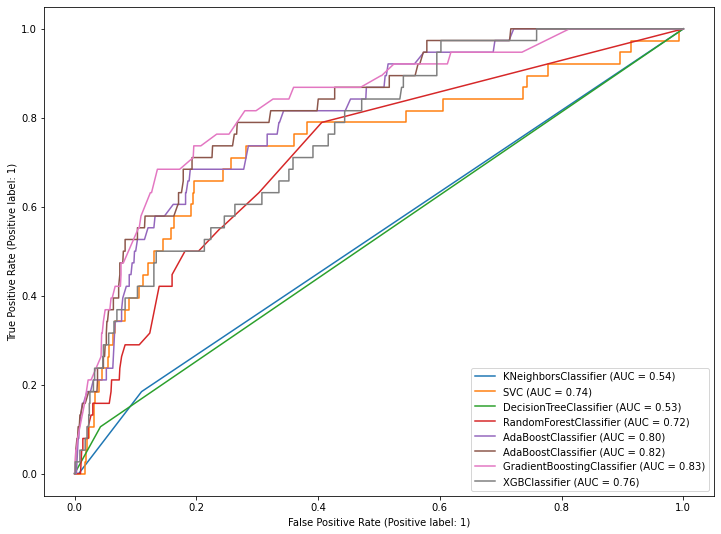

In [ ]:
# Plotting a figure of width 6 and height 3
plt_1 = plt.figure(figsize=(12, 9))

ax = plt.gca()

for classifier in classifiers:

    classifier.fit(X_train, y_train)

    print("\n" + str(classifier))
    print("model score: %.3f" % classifier.score(X_test, y_test))

    print ('===========================')
    y_pred = classifier.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    print(cm)
    print(classification_report(y_test, y_pred, zero_division=0))

    print ('===========================')
    clf_disp = RocCurveDisplay.from_estimator(classifier, X_test, y_test, ax=ax)

plt.show()

### Fine tuning of the classifiers
Due to time consuming it has been commented out. If interested run each classifier by itself

In [ ]:
# clf = xgb.XGBClassifier(learning_rate=0.02, objective='binary:logistic',
#                     silent=True, nthread=1, use_label_encoder=False, eval_metric='logloss')

# clf = AdaBoostClassifier(random_state=0)

# clf = GradientBoostingClassifier(random_state=0)

# #########################

# clf_pipe = Pipeline(steps=
#     [
#         ('preprocessor', preprocessor), 
#         ('clf', clf)
#     ]
# )

############################

# SVC
# parameters = [
#     {
#         'clf__kernel': ["rbf", "linear", "poly", "sigmoid"],
#         'clf__C': [0.1, 1, 2, 3, 5, 10, 100],
#         'clf__gamma': [1, 0.1, 0.01, 0.001],
#     }
# ]

# # XGB
# parameters = [
#     {
#         'clf__min_child_weight': [1, 5, 10],
#         'clf__n_estimators': [50, 100, 300, 600],
#         'clf__gamma': [0.5, 1, 1.5, 2, 5],
#         'clf__subsample': [0.6, 0.8, 1.0],
#         'clf__colsample_bytree': [0.6, 0.8, 1.0],
#         'clf__max_depth': [3, 4, 5]
#     }
# ] 
# 

# AdaBoostClassifier
# parameters = [
#     {
#         'clf__learning_rate': [0.1, 0.5, 1],
#         'clf__n_estimators': [50, 100, 300, 600],
#     }
# ] 


# # GradientBoostingClassifier
# parameters = [
#     {
#         #'clf__learning_rate': [0.1, 0.5, 1],
#         'clf__n_estimators': [50, 100, 300, 600],
#         # 'clf__subsample': [0.6, 0.8, 1.0],
#         #'clf__max_depth': [1, 3, 5]
#     }
# ] 


#############################

# # Type of scoring used to compare parameter combinations
# acc_scorer = make_scorer(accuracy_score)

# # Run the grid search
# grid_obj = GridSearchCV(clf_pipe, parameters, scoring=acc_scorer, error_score='raise')

#############################

# grid_obj.fit(X_train, y_train)

#############################

# print("Best parameter (CV score=%0.3f):" % grid_obj.best_score_)
# print(grid_obj.best_params_)

## Result

If looking at the validation of the models I would say the winner is the:<br>
### GradientBoostingClassifier
... But hey...<br>
Maybe the dataset is not in balance. Let's check that out.

## Check the imbalance of the target in the dataset

/Users/magnus/miniforge3/envs/tensorflow/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


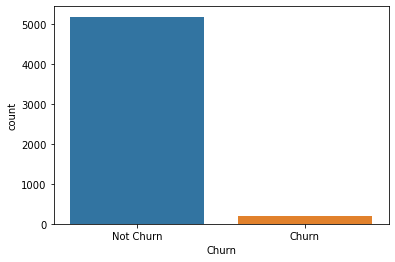

In [ ]:
# visualize the target variable
g = sns.countplot(data['Churn'])
g.set_xticklabels(['Not Churn','Churn'])
plt.show()

### YES, the dataset is imbalanced
Let start over and split up the already preprocessed data 

## Handle the imbalance in the dataset
Can be done with different technices. On the ones I tried (Under- and Over-sampling, SMOTE and NearMiss)<br>
the SMOTE is the best one. Therefor the rest of them is commented out. 

### Importing libraries

In [ ]:
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss
from collections import Counter

### Random under-sampling

In [ ]:
# rus = RandomUnderSampler(random_state=42, replacement=True)# fit predictor and target variable
# X_rus, y_rus = rus.fit_resample(X, y)

# print('original dataset shape:', Counter(y))
# print('Resample dataset shape', Counter(y_rus))

### Random over-sampling

In [ ]:
# ros = RandomOverSampler(random_state=42)
# X_ros, y_ros = ros.fit_resample(X, y)

# print('Original dataset shape', Counter(y))
# print('Resample dataset shape', Counter(y_ros))

### SMOTE

In [ ]:
smote = SMOTE()
X_smote, y_smote = smote.fit_resample(X, y)

print('Original dataset shape', Counter(y))
print('Resample dataset shape', Counter(y_smote))

Original dataset shape Counter({0: 5174, 1: 200})
Resample dataset shape Counter({0: 5174, 1: 5174})


### NearMiss 

In [ ]:
# nm = NearMiss()
# X_nm, y_nm = nm.fit_resample(X, y)

# print('Original dataset shape:', Counter(y))
# print('Resample dataset shape:', Counter(y_nm))

## Splitting up data to train and test sets... again...
This time using the SMOTE values

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_smote, y_smote, test_size=0.2, random_state=0)

# And again test the data with all models
Once again starting with a deep learning one

### Building a neural network - Deep Learning

#### Initliazing the ANN

In [ ]:
ann = tf.keras.models.Sequential()

#### Adding the input layer and the first hidden layer

In [ ]:
ann.add(tf.keras.layers.Dense(units=6, activation='relu'))

#### Adding the second hidden layer

In [ ]:
ann.add(tf.keras.layers.Dense(units=6, activation='relu'))

#### Adding the output layer

In [ ]:
ann.add(tf.keras.layers.Dense(units=1, activation='sigmoid'))

#### Compiling the ann

In [ ]:
ann.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

### Training the ann on the training set

In [ ]:
ann.fit(X_train, y_train, batch_size=32, epochs=100)

Epoch 1/100
 16/259 [>.............................] - ETA: 1s - loss: 0.7103 - accuracy: 0.4238

2022-06-22 16:10:55.186261: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


259/259 [==============================] - 2s 7ms/step - loss: 0.6076 - accuracy: 0.6845
Epoch 2/100
259/259 [==============================] - 2s 7ms/step - loss: 0.4910 - accuracy: 0.7652
Epoch 3/100
259/259 [==============================] - 2s 7ms/step - loss: 0.4774 - accuracy: 0.7736
Epoch 4/100
259/259 [==============================] - 2s 6ms/step - loss: 0.4710 - accuracy: 0.7758
Epoch 5/100
259/259 [==============================] - 2s 7ms/step - loss: 0.4664 - accuracy: 0.7752
Epoch 6/100
259/259 [==============================] - 2s 6ms/step - loss: 0.4631 - accuracy: 0.7766
Epoch 7/100
259/259 [==============================] - 1s 6ms/step - loss: 0.4605 - accuracy: 0.7743
Epoch 8/100
259/259 [==============================] - 1s 6ms/step - loss: 0.4574 - accuracy: 0.7747
Epoch 9/100
259/259 [==============================] - 1s 6ms/step - loss: 0.4553 - accuracy: 0.7760
Epoch 10/100
259/259 [==============================] - 2s 8ms/step - loss: 0.4520 - accuracy: 0.7763
E

#### Make predictions form ANN

In [ ]:
### Make predictions
y_pred = ann.predict(X_test)
y_pred = (y_pred > 0.5)
y_pred=y_pred.astype(int) # Convert boolean to int


2022-06-22 16:13:45.046372: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


#### Validate the ANN model

In [ ]:
### Confusion matrix and accurucy score
cm = confusion_matrix(y_test, y_pred)
print (cm)

accuracy_score(y_test, y_pred)

print(classification_report(y_test, y_pred, zero_division=0))


[[751 274]
 [137 908]]
              precision    recall  f1-score   support

           0       0.85      0.73      0.79      1025
           1       0.77      0.87      0.82      1045

    accuracy                           0.80      2070
   macro avg       0.81      0.80      0.80      2070
weighted avg       0.81      0.80      0.80      2070



### Again test the different classifiers to see which one matches the problem the best

### Without fine tuning (actually gave best scores)

In [ ]:
classifiers = [
    KNeighborsClassifier(3),
    SVC(kernel="rbf", C=0.025, probability=True, class_weight='balanced', random_state=0),
    DecisionTreeClassifier(random_state=0),
    RandomForestClassifier(n_estimators=100, random_state=0),
    AdaBoostClassifier(random_state=0),
    GradientBoostingClassifier(random_state=0),
    xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')
    ]


### Making prediction and calculate which model is the better one


KNeighborsClassifier(n_neighbors=3)
model score: 0.883
[[839 186]
 [ 56 989]]
              precision    recall  f1-score   support

           0       0.94      0.82      0.87      1025
           1       0.84      0.95      0.89      1045

    accuracy                           0.88      2070
   macro avg       0.89      0.88      0.88      2070
weighted avg       0.89      0.88      0.88      2070


SVC(C=0.025, class_weight='balanced', probability=True, random_state=0)
model score: 0.764
[[742 283]
 [205 840]]
              precision    recall  f1-score   support

           0       0.78      0.72      0.75      1025
           1       0.75      0.80      0.77      1045

    accuracy                           0.76      2070
   macro avg       0.77      0.76      0.76      2070
weighted avg       0.77      0.76      0.76      2070


DecisionTreeClassifier(random_state=0)
model score: 0.897
[[918 107]
 [107 938]]
              precision    recall  f1-score   support

           0   

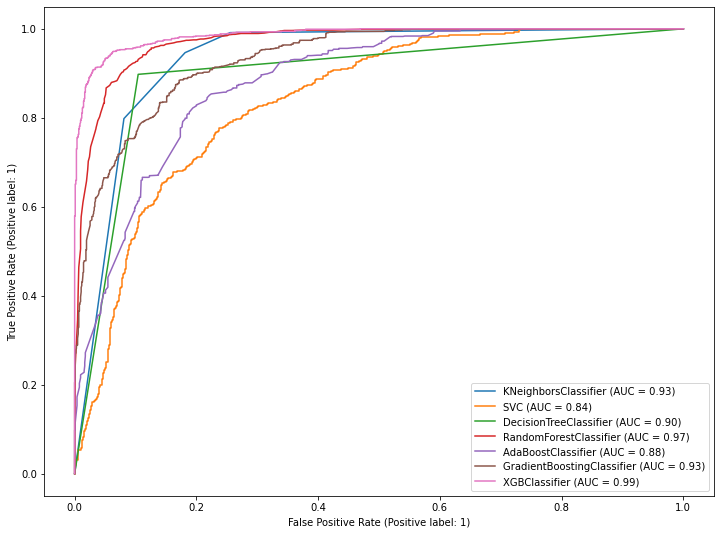

In [ ]:
# Plotting a figure of width 6 and height 3
plt_1 = plt.figure(figsize=(12, 9))

ax = plt.gca()

for classifier in classifiers:

    classifier.fit(X_train, y_train)

    print("\n" + str(classifier))
    print("model score: %.3f" % classifier.score(X_test, y_test))

    print ('===========================')
    y_pred = classifier.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    print(cm)
    print(classification_report(y_test, y_pred, zero_division=0))

    print ('===========================')
    clf_disp = RocCurveDisplay.from_estimator(classifier, X_test, y_test, ax=ax)

plt.show()


## And the winner is XGBoost Classifier

When handled the imbalance in the dataset I recieve more spread out results which can be seen in the confusion matrix. But also interesting that both XGBClassifier and RandomForestClassifier turns out really well.<br> 
Overfitted? That is a though that comes to mind...